# homuncu_loc image viewer

In [7]:
import napari
from skimage import io
import btrack
import os
from homuncu_loc import dataio
from glob import glob

### Define base directory and image ID

In [14]:
img_base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/images'
image_base_name = '20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237.tif' 
image_fn = os.path.join(img_base_dir, image_base_name)
image_id = dataio.ID_extractor(image_fn)
print(f"File '{image_base_name}' {'exists.' if os.path.exists(image_fn) else 'does not exist.'}")

File '20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237.tif' exists.


### Load image

In [ ]:
image = io.imread(image_fn)
print(f'Image of shape {image.shape} loaded')

### Search for associated single-cell segmentation and tracking data

In [9]:
# base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses'
sc_base_dir = img_base_dir.replace('images', 'sc_analyses') 
sc_fns = glob(os.path.join(sc_base_dir, f'*_{image_id}*.h5'))
print(sc_fns)

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5']


### Load single-cell data

In [10]:
sc_fn = sc_fns[0]
# load labels (tracks and segmentation)
with btrack.io.HDF5FileHandler(sc_fn, 
                                   'r', 
                                       obj_type='obj_type_2'#'obj_type_2'
                                   ) as reader:
        # tracks = [t for t in reader.tracks if np.mean(t.properties['area']) > 1000]
        tracks = [t for t in reader.tracks if len(t) >= 3]
        segmentation = reader.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

[INFO][2023/10/16 11:06:00 AM] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5...
[INFO][2023/10/16 11:06:00 AM] Loading tracks/obj_type_2
[INFO][2023/10/16 11:06:00 AM] Loading LBEP/obj_type_2
[INFO][2023/10/16 11:06:00 AM] Loading objects/obj_type_2 (28241, 5) (28241 filtered: None)
[INFO][2023/10/16 11:06:04 AM] Loading segmentation (81, 2304, 2304)
[INFO][2023/10/16 11:06:04 AM] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5


##### Optionally recolour segmentation according to Cell ID

In [15]:
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks, color_by='ID')

### View images and single-cell data

In [16]:
viewer = napari.Viewer()

viewer.add_image(image, channel_axis = -1)
# viewer.add_labels(segmentation, visible = False)
viewer.add_labels(recolored_segmentation)
viewer.add_tracks(napari_tracks)

<Tracks layer 'napari_tracks' at 0x7f4194b70d30>

In [20]:
viewer.add_image(segmentation)

<Image layer 'segmentation' at 0x7f3ffc1a96a0>

In [17]:
print()

In [39]:
viewer.camera.zoom = 0.465

In [32]:
import matplotlib.pyplot as plt

In [49]:
import numpy as np
from PIL import Image

def trim_black_border(image: Image.Image) -> Image.Image:
    """
    Trims the black border around a PIL Image.
    
    Parameters:
    - image: A PIL Image object.
    
    Returns:
    - A new PIL Image object with the black border trimmed.
    """
    
    # Convert the image to an array
    im_array = image #np.array(image)
    
    # Find all rows and columns where the image isn't black
    non_black_rows = np.any(im_array != [0, 0, 0, 0], axis=1)
    non_black_columns = np.any(im_array != [0, 0, 0, 0], axis=0)
    
    # Find the first and last non-black row and column indices
    first_row, last_row = np.where(non_black_rows)[0][[0, -1]]
    first_col, last_col = np.where(non_black_columns)[0][[0, -1]]
    
    # Crop the image based on these indices
    cropped_array = im_array[first_row:last_row + 1, first_col:last_col + 1]
    
    return Image.fromarray(cropped_array)

# # Usage:
# viewer_image = Image.open("path_to_screenshot.png")  # You can replace this with your viewer.screenshot()
# trimmed_image = trim_black_border(viewer_image)
# trimmed_image.show()


In [48]:
viewer.screenshot().shape

(1082, 1091, 4)

In [65]:
screenshot.shape

(1042, 1042, 4)

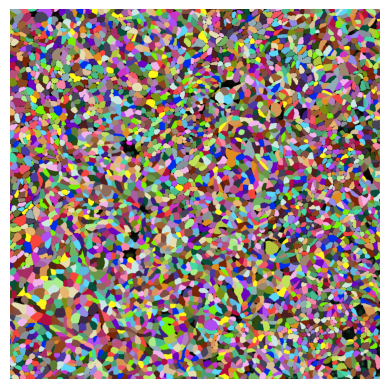

In [66]:
crop_amount = 20
screenshot = viewer.screenshot()[crop_amount:-crop_amount, crop_amount:-crop_amount-9]
plt.imshow(screenshot)
plt.axis('off')
plt.savefig(f'/home/dayn/data/homuncu_loc_temp/{image_base_name}_z36_segmented.png', dpi = 314, bbox_inches = 'tight')

In [34]:
viewer.screenshot()

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0